<a href="https://colab.research.google.com/github/Charul00/AI-Powered-/blob/main/notebooks/MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Install Dependencies

In [2]:
import os
import math
import shutil
import glob
import keras
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
# ImageDataGenerator moved to tf.keras.utils.image_dataset_from_directory or tf.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Changed import statement
from keras.layers import Flatten, Dense
from keras.models import Model, load_model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


# 1. Fetch dataset from kaggle

In [3]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mehradaria/leukemia # Download Dataset
! unzip leukemia.zip # Unzip

Streaming output truncated to the last 5000 lines.
  inflating: Original/Pre/WBC-Malignant-Pre-024.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-025.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-026.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-027.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-028.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-029.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-030.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-031.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-032.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-033.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-034.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-035.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-036.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-037.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-038.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-039.jpg  
  inflating: Original/Pre/WBC-Malignant-Pre-040.jpg  
  inflating: Original/Pre/WBC-M

In [4]:
# Count the number of images in the respective classes
def ClassFreq(ROOT_DIR):
  number_of_images = {}
  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir))) # os.listdir() returns the elements on the specific folder
  print(number_of_images.items())

ClassFreq("/content/Original")

dict_items([('Benign', 504), ('Pre', 963), ('Early', 985), ('Pro', 804)])


# 3. Split Dataset

In [5]:
ROOT_DIR = "/content/Original"

def dataFolder(path, split):
  number_of_images = {}
  for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

  # Creates directory for train, test and validation set
  # Create separate folders for Training, Validation and Testing
  if not os.path.exists("./"+path): # When <path> directory is not available in the root directory
    os.mkdir("./"+path)             # make directory

    for dir in os.listdir(ROOT_DIR): #For the classes in the Root directory
      os.makedirs("./"+path+"/"+dir)      # create new directoris

      for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)), size = (math.floor(split*number_of_images[dir])-5), replace = False):
        O = os.path.join(ROOT_DIR, dir, img)
        D = os.path.join("./"+path, dir)
        shutil.copy(O,D)
        os.remove(O)

  else:
    print(f"{path} directory already exists")

  print(f"{path} directory has been created")


#Split Dataset and create directory
dataFolder("train",0.7)
dataFolder("val",0.15)
dataFolder("test",0.15)

#Show data frequency
ClassFreq("/content/train")
ClassFreq("/content/val")
ClassFreq("/content/test")

train directory has been created
val directory has been created
test directory has been created
dict_items([('Benign', 347), ('Pre', 669), ('Early', 684), ('Pro', 557)])
dict_items([('Benign', 18), ('Pre', 39), ('Early', 40), ('Pro', 32)])
dict_items([('Benign', 15), ('Pre', 33), ('Early', 34), ('Pro', 27)])


# 4. Preprocessing Images

In [6]:
def preprocessingImages(path):
  """
  Input: path
  Output: Generated Data
  """
  image_data = ImageDataGenerator(zoom_range = 0.2, shear_range=0.2,preprocessing_function=preprocess_input, horizontal_flip=True)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size = 32,  class_mode= "categorical")
  train_step = image.n//32
  return image, train_step

In [7]:
def ScaleImages(path):
  """
  Input: path
  Output: Generated Data
  """
  image_data = ImageDataGenerator(preprocessing_function=preprocess_input)
  image = image_data.flow_from_directory(directory=path, target_size=(224,224), batch_size = 32, class_mode= "categorical")
  steps = image.n//32
  return image, steps

In [8]:
train_path = "/content/train"
test_path = "/content/test"
val_path = "/content/val"

train_data, train_step = preprocessingImages(train_path)
val_data, val_steps = ScaleImages(val_path)
test_data, test_steps = ScaleImages(test_path)

train_data.class_indices
print(test_data.class_indices)
print(val_data.class_indices)

Found 2257 images belonging to 4 classes.
Found 129 images belonging to 4 classes.
Found 109 images belonging to 4 classes.
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}


# 5. Model Building

In [9]:
# Downloading MobileNet model
base_model = MobileNet(input_shape=(224,224,3), include_top=False)

for layer in base_model.layers:
  layer.trainable = False

X= Flatten()(base_model.output)
X= Dense(units=4, activation="softmax")(X)
model = Model(base_model.input, X)
model.compile(optimizer="rmsprop", loss=keras.losses.categorical_crossentropy, metrics = ["accuracy"])

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,429,572 (13.08 MB)

 Trainable params: 200,708 (784.02 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

# 6. Training and Validation

In [12]:
mc = ModelCheckpoint(filepath="bestmodel.h5",
                     monitor="val_accuracy",
                     verbose=1,
                     save_best_only = True)

es = EarlyStopping(monitor="val_accuracy",
                   min_delta=0.01,
                   patience= 11,
                   verbose=1)
cb = [mc,es]
hist = model.fit(train_data,
                           steps_per_epoch=train_step,
                           epochs = 70,
                           validation_data = val_data,
                           validation_steps=val_steps,
                           callbacks=cb)

Epoch 1/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6837 - loss: 5.5109
Epoch 1: val_accuracy improved from -inf to 0.87500, saving model to bestmodel.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 36s 416ms/step - accuracy: 0.6852 - loss: 5.4732 - val_accuracy: 0.8750 - val_loss: 0.7774
Epoch 2/70
 1/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.8750 - loss: 2.4211
Epoch 2: val_accuracy improved from 0.87500 to 0.89844, saving model to bestmodel.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8750 - loss: 2.4211 - val_accuracy: 0.8984 - val_loss: 0.5896
Epoch 3/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8970 - loss: 1.0898
Epoch 3: val_accuracy improved from 0.89844 to 0.96875, saving model to bestmodel.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 491ms/step - accuracy: 0.8968 - loss: 1.0917 - val_accuracy: 0.9688 - val_loss: 0.4846
Epoch 4/70
 1/70 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8438 - loss: 2.0215
Epoch 4: val_accuracy improved from 0.96875 to 0.97656, saving model to bestmodel.h5


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 2.0215 - val_accuracy: 0.9766 - val_loss: 0.2716
Epoch 5/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9331 - loss: 0.6233
Epoch 5: val_accuracy did not improve from 0.97656
70/70 ━━━━━━━━━━━━━━━━━━━━ 26s 372ms/step - accuracy: 0.9330 - loss: 0.6252 - val_accuracy: 0.9141 - val_loss: 0.5972
Epoch 6/70
 1/70 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.8438 - loss: 1.4243
Epoch 6: val_accuracy did not improve from 0.97656
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8438 - loss: 1.4243 - val_accuracy: 0.9609 - val_loss: 0.2631
Epoch 7/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9548 - loss: 0.5521
Epoch 7: val_accuracy did not improve from 0.97656
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 588ms/step - accuracy: 0.9548 - loss: 0.5523 - val_accuracy: 0.9766 - val_loss: 0.3754
Epoch 8/70
 1/70 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 4.5882e-05
Epoch 8: val_accuracy did not imp

70/70 ━━━━━━━━━━━━━━━━━━━━ 66s 364ms/step - accuracy: 0.9586 - loss: 0.4606 - val_accuracy: 0.9922 - val_loss: 0.2331
Epoch 10/70
 1/70 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 10: val_accuracy did not improve from 0.99219
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9922 - val_loss: 0.2208
Epoch 11/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9520 - loss: 0.4726
Epoch 11: val_accuracy did not improve from 0.99219
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 368ms/step - accuracy: 0.9521 - loss: 0.4719 - val_accuracy: 0.9922 - val_loss: 0.3227
Epoch 12/70
 1/70 ━━━━━━━━━━━━━━━━━━━━ 20s 291ms/step - accuracy: 0.9688 - loss: 0.0314
Epoch 12: val_accuracy did not improve from 0.99219
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9688 - loss: 0.0314 - val_accuracy: 0.9609 - val_loss: 0.4186
Epoch 13/70
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.9579 - loss: 0.4230
Epoch 13: val_accuracy did no

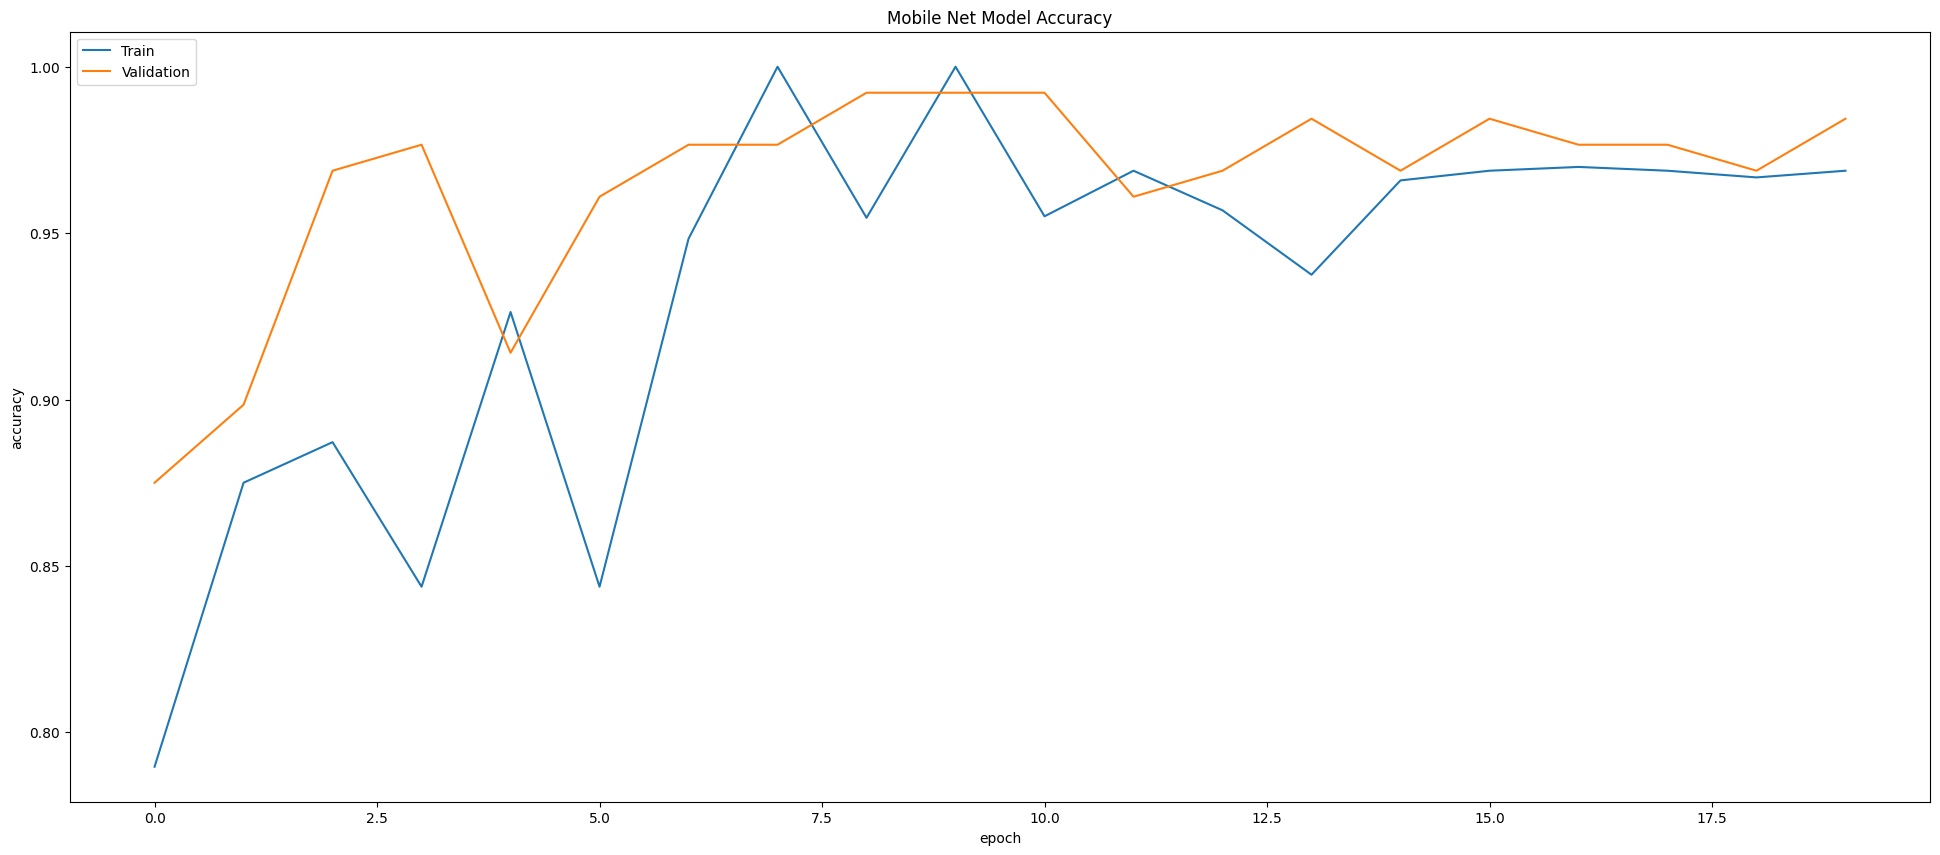

In [13]:
# summarize history for accuracy --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Mobile Net Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Accuracy2.png")
plt.show()

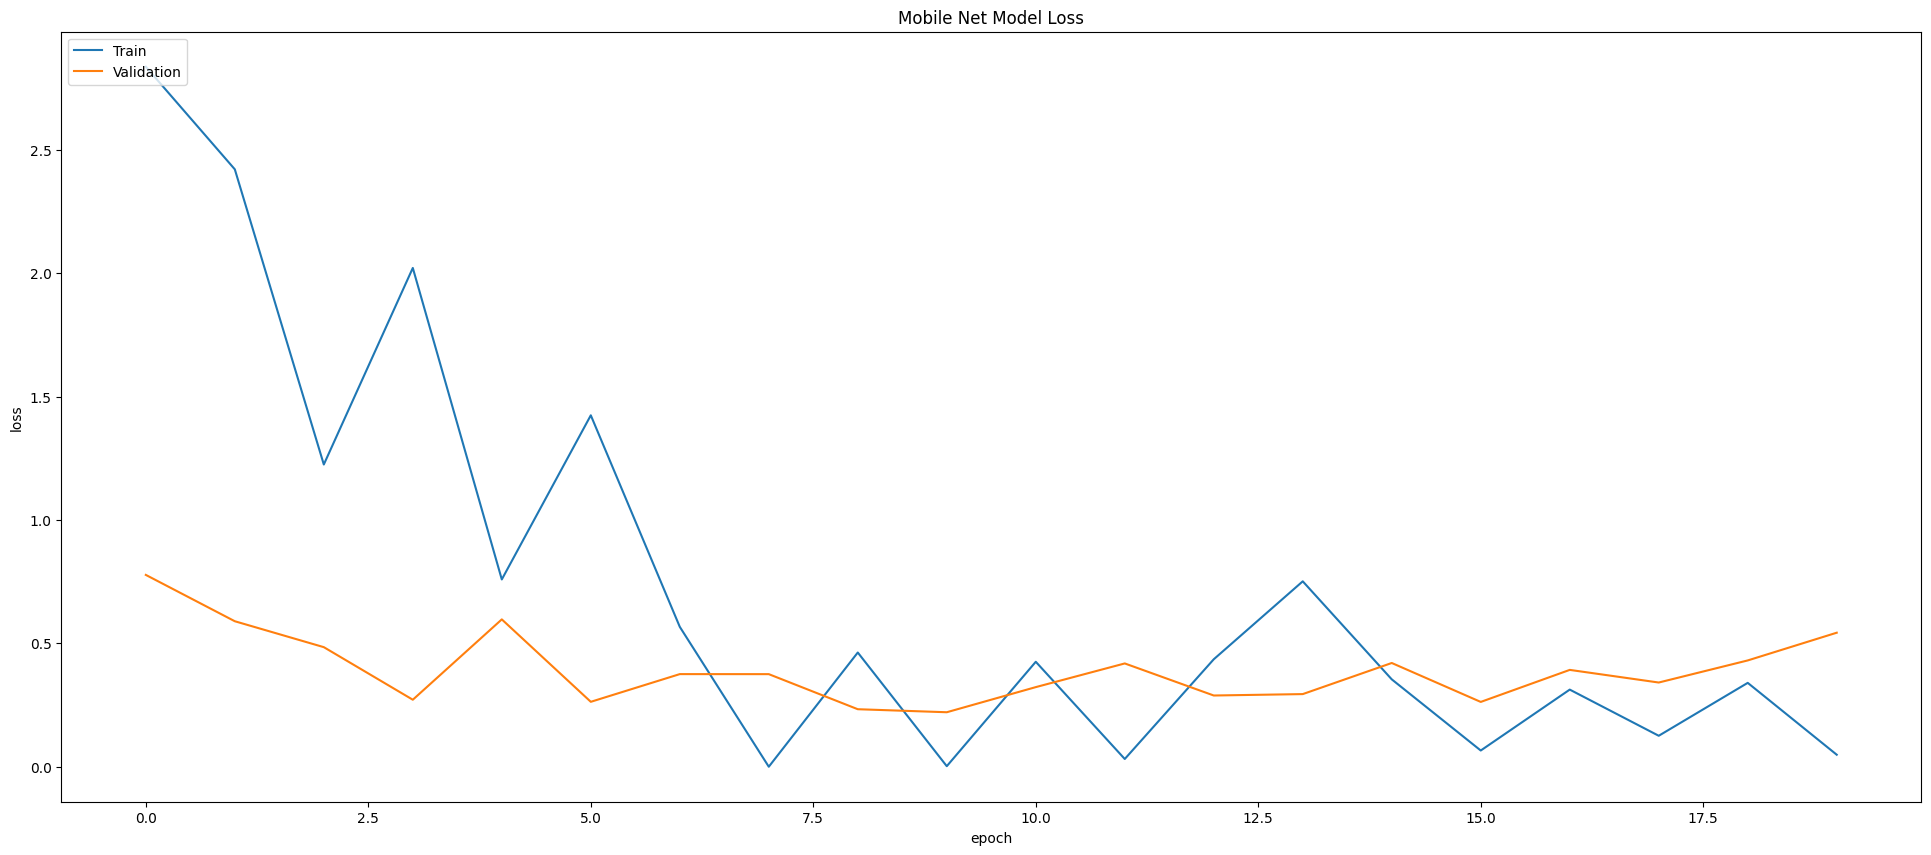

In [14]:
# summarize history for loss --- SAVE
plt.figure(figsize=(24, 10))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Mobile Net Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("MobileNet_Validation2.png")
plt.show()

# 8. Testing Model

In [16]:
best_model_path = "/content/bestmodel.h5"
model = load_model(best_model_path)

# Use evaluate() instead of evaluate_generator() (deprecated)
loss, accuracy = model.evaluate(test_data)

# Convert accuracy to percentage
accuracy_percentage = accuracy * 100

# Print formatted output
print(f"Accuracy: {accuracy_percentage:.2f}% and Loss: {loss:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.9911 - loss: 0.2164
Accuracy: 99.08% and Loss: 0.2233


In [20]:
import os
print(os.listdir('/content/test/Benign/'))

['WBC-Benign-296.jpg', 'WBC-Benign-262.jpg', 'WBC-Benign-337.jpg', 'WBC-Benign-472.jpg', 'WBC-Benign-132.jpg', 'WBC-Benign-187.jpg', 'WBC-Benign-138.jpg', 'WBC-Benign-388.jpg', 'WBC-Benign-303.jpg', 'WBC-Benign-194.jpg', 'WBC-Benign-009.jpg', 'WBC-Benign-063.jpg', 'WBC-Benign-321.jpg', 'WBC-Benign-023.jpg', 'WBC-Benign-167.jpg']


# 9. Random Predict

['WBC-Benign-296.jpg', 'WBC-Benign-262.jpg', 'WBC-Benign-337.jpg', 'WBC-Benign-472.jpg', 'WBC-Benign-132.jpg', 'WBC-Benign-187.jpg', 'WBC-Benign-138.jpg', 'WBC-Benign-388.jpg', 'WBC-Benign-303.jpg', 'WBC-Benign-194.jpg', 'WBC-Benign-009.jpg', 'WBC-Benign-063.jpg', 'WBC-Benign-321.jpg', 'WBC-Benign-023.jpg', 'WBC-Benign-167.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Cancer Not Detected (Healthy Cells)



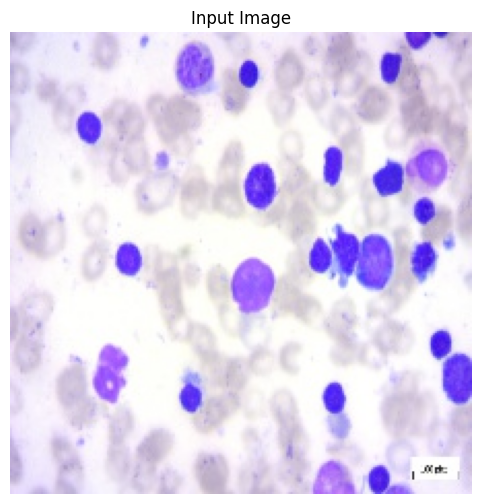

In [21]:
import os

# Print the files in the directory to check if the image exists
print(os.listdir('/content/test/Benign/'))

def random_predict(path):
    img = load_img(path, target_size=(224, 224))
    input_arr = img_to_array(img) / 255.0
    input_arr = np.array([input_arr])

    pred = np.argmax(model.predict(input_arr))

    # Cancer Detection Logic
    if pred == 0:
        print("Cancer Not Detected (Healthy Cells)")
    else:
        print("Cancer Detected")

    print()

    # Display Image
    plt.figure(figsize=(6, 6))
    plt.imshow(input_arr[0])
    plt.title("Input Image")
    plt.axis("off")
    plt.show()


# Example test image
path = "/content/test/Benign/WBC-Benign-167.jpg"  # Verify this path
random_predict(path)

In [ ]:
# convert notebook to html
! pip install nbconvert
! jupyter nbconvert --to html ALL_Cancer_Stage_Detection_using_MobileNet.ipynb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[NbConvertApp] Converting notebook ALL_Cancer_Stage_Detection_using_MobileNet.ipynb to html
[NbConvertApp] Writing 1163029 bytes to ALL_Cancer_Stage_Detection_using_MobileNet.html
